In [ ]:
# %%

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define training parameters
training_start_date = '1970-02-02'
training_end_date = '2024-06-01'
prediction_start_date = '2024-06-02'
prediction_end_date = '2024-10-25'
n_future = 1
batch_size = 16
hidden_size = 64
output_size = 1

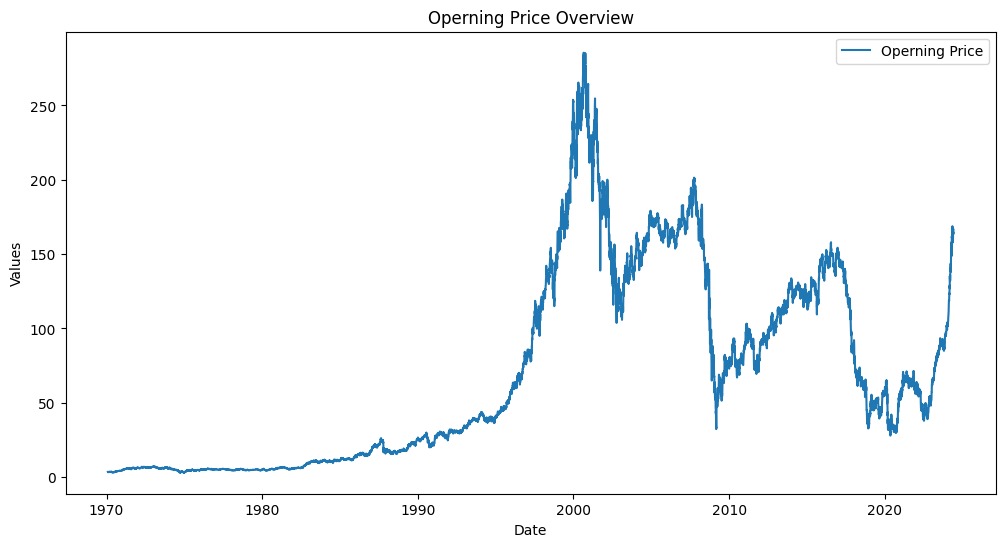

In [ ]:
# %% 

df_full = pd.read_csv('data/Yahoo/yahoo_finance.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])

cols = list(df_full)[1:2]  # Adjust based on your DataFrame structure
df_for_training = df_full[(df_full['Date'] >= training_start_date) & (df_full['Date'] <= training_end_date)][cols].astype(float)

# Convert 'Date' column to index for time series analysis
df_for_training.set_index(df_full[(df_full['Date'] >= training_start_date) & (df_full['Date'] <= training_end_date)]['Date'], inplace=True)

# Plot the time series data for a visual check
plt.figure(figsize=(12, 6))
plt.plot(df_for_training, label="Operning Price")
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Operning Price Overview')
plt.legend()
plt.show()

In [ ]:
# %%

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Use only the last output
        x = self.fc(x)
        return x


# Prepare the training data
def prepare_data(df, n_past):
    cols = list(df)[1:6]  # Adjust based on your DataFrame structure
    df_for_training = df[(df['Date'] >= training_start_date) & (df['Date'] <= training_end_date)][cols].astype(float)

    # Normalize training data 
    scaler = StandardScaler()
    df_for_training_scaled = scaler.fit_transform(df_for_training)

    # Prepare data for LSTM
    trainX, trainY = [], []
    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, :])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])  # Predicting the first column

    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY, scaler, df_for_training, cols


# Define function to train model with a given window size
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_model(n_past, patience=5, min_delta=0.001):
    # Prepare data and initialize variables
    trainX, trainY, scaler, df_for_training, cols = prepare_data(df_full, n_past)

    # Convert numpy arrays to torch tensors
    trainX = torch.from_numpy(trainX).float()
    trainY = torch.from_numpy(trainY).float().view(-1, 1)

    # Initialize rolling window parameters
    total_size = len(trainX)
    start = 0
    metrics = []

    # Iterate over the data with a rolling window
    while start + n_past < total_size:
        end = start + n_past
        trainX_window, valX_window = trainX[start:end], trainX[end:end + n_past]
        trainY_window, valY_window = trainY[start:end], trainY[end:end + n_past]

        # Create data loaders for training and validation
        train_dataset = torch.utils.data.TensorDataset(trainX_window, trainY_window)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Initialize model, criterion, and optimizer
        model = LSTMModel(input_size=trainX.shape[2], hidden_size=hidden_size, output_size=output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Early stopping parameters
        best_val_loss = float("inf")
        patience_counter = 0

        # Train with early stopping for each window
        for epoch in range(1000):  # Use a large number of epochs; training will stop early if needed
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(valX_window)
                val_loss = criterion(val_outputs, valY_window).item()

            print(f"Window [{start}:{end}], Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping check
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience_counter = 0  # Reset counter if validation loss improves
                best_model_weights = model.state_dict()  # Save the best model weights
            else:
                patience_counter += 1

            # Stop if patience is reached
            if patience_counter >= patience:
                print("Early stopping triggered for current window.")
                model.load_state_dict(best_model_weights)
                break

        # Calculate validation metrics for the current window
        val_outputs = val_outputs.numpy()
        valY_window_np = valY_window.numpy()
        mse = mean_squared_error(valY_window_np, val_outputs)
        mae = mean_absolute_error(valY_window_np, val_outputs)
        r2 = r2_score(valY_window_np, val_outputs)
        metrics.append((mse, mae, r2))

        # Advance the window
        start += n_past

    # Aggregate results from all windows
    avg_mse = np.mean([m[0] for m in metrics])
    avg_mae = np.mean([m[1] for m in metrics])
    avg_r2 = np.mean([m[2] for m in metrics])

    print(f"Rolling Window Average - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")

    # Make predictions with the final model trained on the last window
    make_predictions(n_past, model, scaler, df_for_training, cols)

    return avg_mse, avg_mae, avg_r2

In [ ]:
# %%

# Define function to make predictions and visualize results
def make_predictions(n_past, model, scaler, df_for_training, cols):
    # Filter dataset by prediction date range
    df_prediction_temp = df_full[(df_full['Date'] >= prediction_start_date) & (df_full['Date'] <= prediction_end_date)]
    
    # Normalize prediction data
    df_prediction_scaled = scaler.transform(df_prediction_temp[cols].astype(float))

    predictionX = []
    for i in range(n_past, len(df_prediction_scaled) - n_future + 1):
        predictionX.append(df_prediction_scaled[i - n_past:i, :])

    predictionX = np.array(predictionX)
    predictionX_tensor = torch.from_numpy(predictionX).float()

    model.eval()
    with torch.no_grad():
        predictions = model(predictionX_tensor)

    # Inverse transform the predictions to original scale
    predictions_inverse = scaler.inverse_transform(
        np.concatenate([predictions.numpy(), np.zeros((predictions.shape[0], df_for_training.shape[1] - 1))], axis=1)
    )[:, 0]

    # Also inverse-transform actual values for comparison
    actual_values = df_prediction_temp['Open'].iloc[n_past:].values

    # Plotting Actual vs Predicted
    plt.figure(figsize=(14, 7))
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], actual_values, label='Actual Open Prices', color='blue')
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], predictions_inverse, label='Predicted Open Prices', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.title(f'Actual vs Predicted Open Prices (Window Size: {n_past})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# %%

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Use only the last output
        x = self.fc(x)
        return x


# Prepare the training data
def prepare_data(df, n_past):
    cols = list(df)[1:6]  # Adjust based on your DataFrame structure
    df_for_training = df[(df['Date'] >= training_start_date) & (df['Date'] <= training_end_date)][cols].astype(float)

    # Normalize training data 
    scaler = StandardScaler()
    df_for_training_scaled = scaler.fit_transform(df_for_training)

    # Prepare data for LSTM
    trainX, trainY = [], []
    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, :])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])  # Predicting the first column

    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY, scaler, df_for_training, cols


# Define function to train model with a given window size
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_model(n_past, patience=5, min_delta=0.001):
    # Prepare data and initialize variables
    trainX, trainY, scaler, df_for_training, cols = prepare_data(df_full, n_past)

    # Convert numpy arrays to torch tensors
    trainX = torch.from_numpy(trainX).float()
    trainY = torch.from_numpy(trainY).float().view(-1, 1)

    # Initialize rolling window parameters
    total_size = len(trainX)
    start = 0
    metrics = []

    # Iterate over the data with a rolling window
    while start + n_past < total_size:
        end = start + n_past
        trainX_window, valX_window = trainX[start:end], trainX[end:end + n_past]
        trainY_window, valY_window = trainY[start:end], trainY[end:end + n_past]

        # Create data loaders for training and validation
        train_dataset = torch.utils.data.TensorDataset(trainX_window, trainY_window)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Initialize model, criterion, and optimizer
        model = LSTMModel(input_size=trainX.shape[2], hidden_size=hidden_size, output_size=output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Early stopping parameters
        best_val_loss = float("inf")
        patience_counter = 0

        # Train with early stopping for each window
        for epoch in range(1000):  # Use a large number of epochs; training will stop early if needed
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(valX_window)
                val_loss = criterion(val_outputs, valY_window).item()

            print(f"Window [{start}:{end}], Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping check
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience_counter = 0  # Reset counter if validation loss improves
                best_model_weights = model.state_dict()  # Save the best model weights
            else:
                patience_counter += 1

            # Stop if patience is reached
            if patience_counter >= patience:
                print("Early stopping triggered for current window.")
                model.load_state_dict(best_model_weights)
                break

        # Calculate validation metrics for the current window
        val_outputs = val_outputs.numpy()
        valY_window_np = valY_window.numpy()
        mse = mean_squared_error(valY_window_np, val_outputs)
        mae = mean_absolute_error(valY_window_np, val_outputs)
        r2 = r2_score(valY_window_np, val_outputs)
        metrics.append((mse, mae, r2))

        # Advance the window
        start += n_past

    # Aggregate results from all windows
    avg_mse = np.mean([m[0] for m in metrics])
    avg_mae = np.mean([m[1] for m in metrics])
    avg_r2 = np.mean([m[2] for m in metrics])

    print(f"Rolling Window Average - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")

    # Make predictions with the final model trained on the last window
    make_predictions(n_past, model, scaler, df_for_training, cols)

    return avg_mse, avg_mae, avg_r2

In [ ]:
# %%

# Define function to make predictions and visualize results
def make_predictions(n_past, model, scaler, df_for_training, cols):
    # Filter dataset by prediction date range
    df_prediction_temp = df_full[(df_full['Date'] >= prediction_start_date) & (df_full['Date'] <= prediction_end_date)]
    
    # Normalize prediction data
    df_prediction_scaled = scaler.transform(df_prediction_temp[cols].astype(float))

    predictionX = []
    for i in range(n_past, len(df_prediction_scaled) - n_future + 1):
        predictionX.append(df_prediction_scaled[i - n_past:i, :])

    predictionX = np.array(predictionX)
    predictionX_tensor = torch.from_numpy(predictionX).float()

    model.eval()
    with torch.no_grad():
        predictions = model(predictionX_tensor)

    # Inverse transform the predictions to original scale
    predictions_inverse = scaler.inverse_transform(
        np.concatenate([predictions.numpy(), np.zeros((predictions.shape[0], df_for_training.shape[1] - 1))], axis=1)
    )[:, 0]

    # Also inverse-transform actual values for comparison
    actual_values = df_prediction_temp['Open'].iloc[n_past:].values

    # Plotting Actual vs Predicted
    plt.figure(figsize=(14, 7))
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], actual_values, label='Actual Open Prices', color='blue')
    plt.plot(df_prediction_temp['Date'].iloc[n_past:], predictions_inverse, label='Predicted Open Prices', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.title(f'Actual vs Predicted Open Prices (Window Size: {n_past})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Window [0:5], Epoch 1, Train Loss: 1.8710, Val Loss: 1.9284
Window [0:5], Epoch 2, Train Loss: 1.7667, Val Loss: 1.8496
Window [0:5], Epoch 3, Train Loss: 1.7876, Val Loss: 1.7714
Window [0:5], Epoch 4, Train Loss: 1.6693, Val Loss: 1.6922
Window [0:5], Epoch 5, Train Loss: 1.5725, Val Loss: 1.6118
Window [0:5], Epoch 6, Train Loss: 1.4930, Val Loss: 1.5294
Window [0:5], Epoch 7, Train Loss: 1.4149, Val Loss: 1.4441
Window [0:5], Epoch 8, Train Loss: 1.3365, Val Loss: 1.3554
Window [0:5], Epoch 9, Train Loss: 1.3852, Val Loss: 1.2637
Window [0:5], Epoch 10, Train Loss: 1.2800, Val Loss: 1.1684
Window [0:5], Epoch 11, Train Loss: 1.1777, Val Loss: 1.0696
Window [0:5], Epoch 12, Train Loss: 1.0364, Val Loss: 0.9671
Window [0:5], Epoch 13, Train Loss: 0.9044, Val Loss: 0.8613
Window [0:5], Epoch 14, Train Loss: 0.7294, Val Loss: 0.7526
Window [0:5], Epoch 15, Train Loss: 0.7611, Val Loss: 0.6427
Window [0:5], Epoch 16, Train Loss: 0.6194, Val Loss: 0.5331
Window [0:5], Epoch 17, Train Los

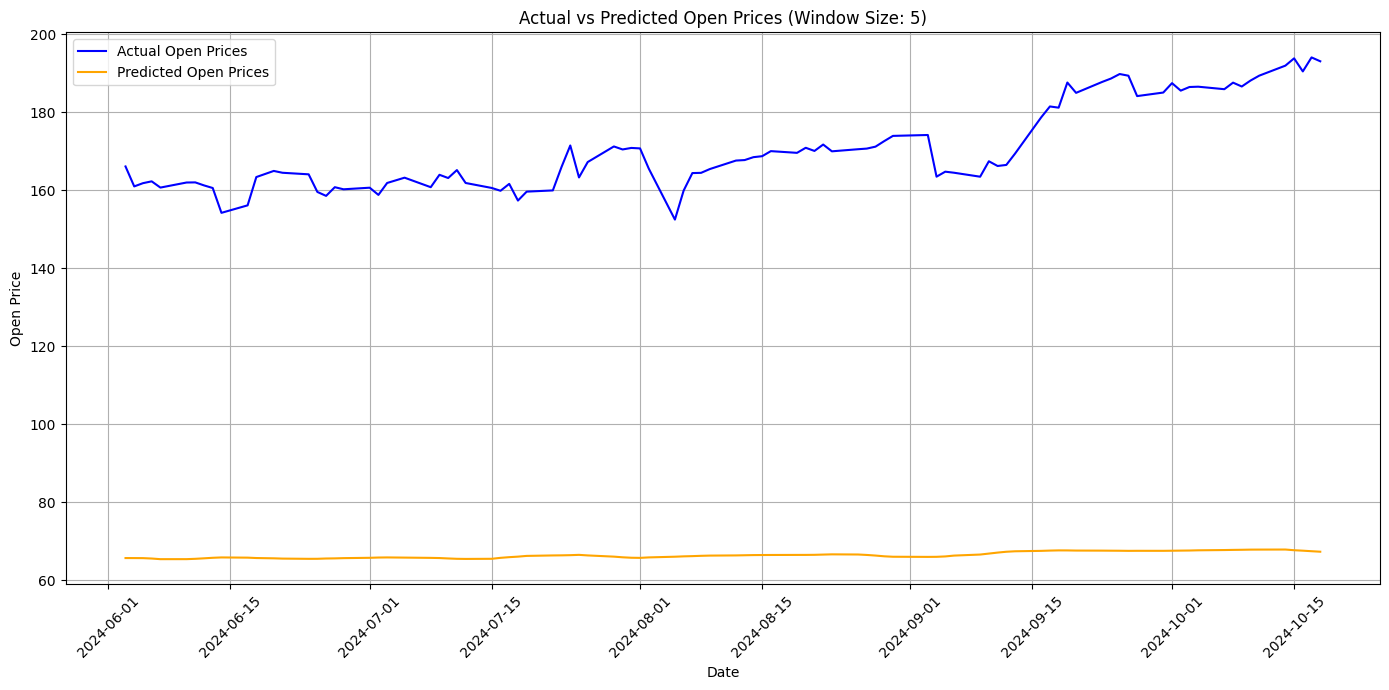

   Window Size       MSE       MAE            R²
0            5  0.040928  0.180992 -56749.765803


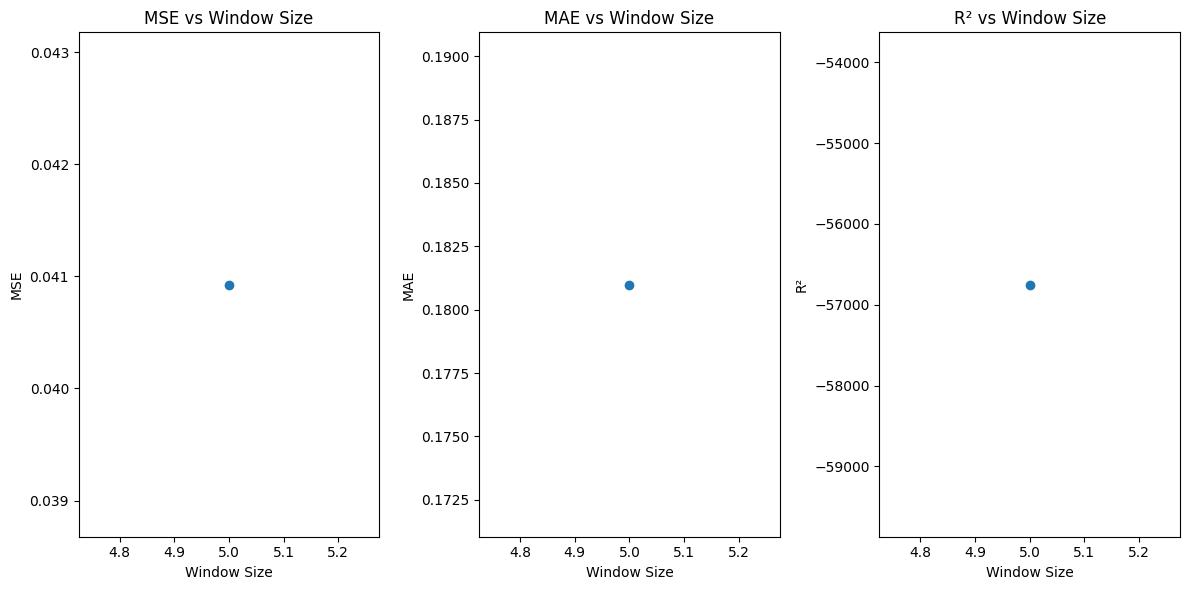

In [ ]:
# %%

# Test different window sizes
window_sizes = [5]  # Example window sizes
results = []
n_past = 5  # Example sequence length for past time steps
batch_size = 32  # Example batch size for training
hidden_size = 64  # Hidden size for LSTM
output_size = 1  # Output size, typically 1 for regression


for window_size in window_sizes:
    mse, mae, r2 = train_model(n_past, patience=5, min_delta=0.001)
    results.append({
        'Window Size': window_size,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

# Create a DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(results_df['Window Size'], results_df['MSE'], marker='o')
plt.title('MSE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MSE')

plt.subplot(1, 3, 2)
plt.plot(results_df['Window Size'], results_df['MAE'], marker='o')
plt.title('MAE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
plt.plot(results_df['Window Size'], results_df['R²'], marker='o')
plt.title('R² vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('R²')

plt.tight_layout()
plt.show()